Dataset loaded with 1159764 rows and 20 columns
Popularity threshold for 'viral' songs: 29.0
Number of viral songs: 295511
Number of non-viral songs: 864237

Splitting and preprocessing data...

Training regression model...
Regression Model Evaluation:
Mean Squared Error: 113.6179
Root Mean Squared Error: 10.6592
Mean Absolute Error: 8.1724
R² Score: 0.5489

Training classification model...
Classification Model Evaluation:
Accuracy: 0.7916
Precision: 0.9211
Recall: 0.1985
F1 Score: 0.3266

Analyzing feature importance...

Top 5 features for popularity prediction:
cat__genre_pop: 36.1378
cat__genre_rock: 25.9602
cat__genre_hip-hop: 25.4098
cat__genre_dance: 23.5164
cat__genre_alt-rock: 19.6823

Top 5 features for virality prediction:
num__year: 0.2433
cat__genre_alt-rock: 0.1155
cat__genre_dance: 0.0921
cat__genre_hip-hop: 0.0911
num__duration_min: 0.0622

Plotting evaluation metrics...


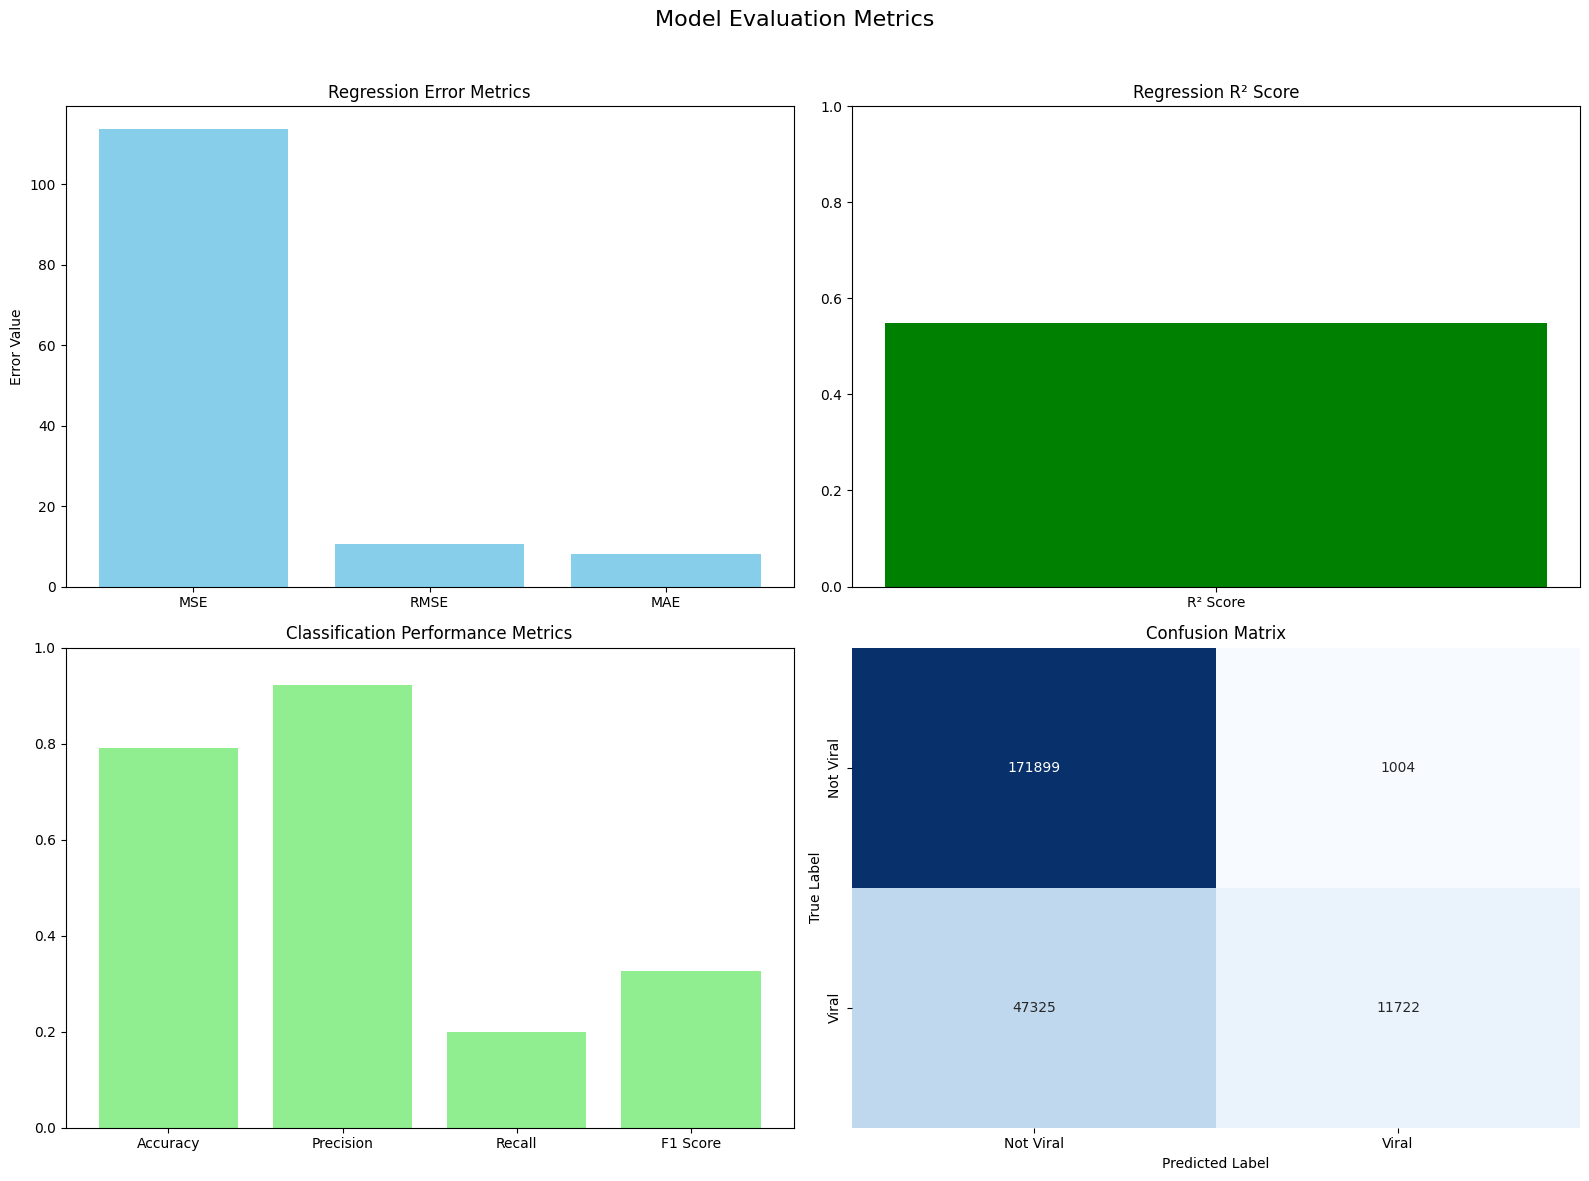

Models saved successfully

Testing prediction on a sample song...
Predicted popularity score: 56.48/100
Viral probability: 62.96%
Is viral: Yes

Total execution time: 117.29 seconds


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# Data preprocessing - simplified and faster
def preprocess_data(df):
    # Drop unnecessary columns
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Drop rows with missing values
    df = df.dropna().reset_index(drop=True)

    # Drop non-numeric columns that won't be used for prediction
    features_to_drop = ['artist_name', 'track_name', 'track_id']
    features_to_drop = [col for col in features_to_drop if col in df.columns]
    df_model = df.drop(features_to_drop, axis=1)

    # Define virality - use popularity as target
    popularity_threshold = df_model['popularity'].quantile(0.75)
    df_model['is_viral'] = (df_model['popularity'] >= popularity_threshold).astype(int)

    print(f"Popularity threshold for 'viral' songs: {popularity_threshold}")
    print(f"Number of viral songs: {df_model['is_viral'].sum()}")
    print(f"Number of non-viral songs: {len(df_model) - df_model['is_viral'].sum()}")

    return df_model

# Simplified feature engineering - only create the most important features
def feature_engineering(df):
    df = df.copy()

    # Only add the most impactful features based on domain knowledge
    if 'energy' in df.columns and 'acousticness' in df.columns:
        df['energy_acousticness_ratio'] = df['energy'] / (df['acousticness'] + 0.01)

    if 'valence' in df.columns and 'energy' in df.columns:
        df['positivity'] = (df['valence'] + df['energy']) / 2

    if 'duration_ms' in df.columns:
        df['duration_min'] = df['duration_ms'] / 60000
        # Drop the original column to reduce dimensionality
        df.drop('duration_ms', axis=1, inplace=True)

    return df

# Identify categorical columns
def identify_column_types(df):
    feature_df = df.drop(['popularity', 'is_viral'], axis=1)
    categorical_cols = feature_df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = feature_df.select_dtypes(include=['number']).columns.tolist()
    return categorical_cols, numerical_cols

# Optimized data splitting and processing
def split_data(df):
    categorical_cols, numerical_cols = identify_column_types(df)

    X = df.drop(['popularity', 'is_viral'], axis=1)
    y_regression = df['popularity']
    y_classification = df['is_viral']

    # Split data
    X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
        X, y_regression, y_classification, test_size=0.2, random_state=42
    )

    # Create preprocessing for numerical and categorical data
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='drop'
    )

    # Preprocess the data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return X_train, X_test, X_train_processed, X_test_processed, y_reg_train, y_reg_test, y_cls_train, y_cls_test, preprocessor

# Faster regression model - Use Ridge instead of GradientBoosting
def train_regression_model(X_train, y_train):
    # Ridge regression is much faster than GradientBoosting and often works well for this type of data
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    return model

# Evaluate the regression model
def evaluate_regression_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Regression Model Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Faster classification model
def train_classification_model(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier

    # Reduced number of trees and depth for faster training
    clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    return clf

# Evaluate the classification model
def evaluate_classification_model(model, X_test, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    predictions = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    print(f"Classification Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'confusion_matrix': cm}

# Simpler feature importance analysis
def analyze_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
        return feature_importance
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
        return feature_importance
    else:
        return None

# Function to test prediction on a sample song
def predict_virality_for_sample(reg_model, cls_model, preprocessor, sample_data):
    sample = pd.DataFrame([sample_data])
    sample = feature_engineering(sample)

    # Drop unnecessary columns if they exist
    if 'popularity' in sample.columns:
        sample = sample.drop(['popularity'], axis=1)
    if 'is_viral' in sample.columns:
        sample = sample.drop(['is_viral'], axis=1)

    # Process the sample using the preprocessor
    sample_processed = preprocessor.transform(sample)

    # Predict popularity score (regression)
    popularity_score = reg_model.predict(sample_processed)[0]

    # Predict virality (classification)
    viral_prob = cls_model.predict_proba(sample_processed)[0][1]
    is_viral = cls_model.predict(sample_processed)[0]

    return {
        'popularity_score': popularity_score,
        'viral_probability': viral_prob,
        'is_viral': bool(is_viral),
    }

# Function to visualize evaluation metrics
def plot_evaluation_metrics(reg_metrics, cls_metrics):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Evaluation Metrics', fontsize=16)

    # Regression metrics visualization
    reg_metrics_names = ['MSE', 'RMSE', 'MAE', 'R²']
    reg_metrics_values = [reg_metrics['mse'], reg_metrics['rmse'], reg_metrics['mae'], reg_metrics['r2']]

    axes[0, 0].bar(reg_metrics_names[:3], reg_metrics_values[:3], color='skyblue')
    axes[0, 0].set_title('Regression Error Metrics')
    axes[0, 0].set_ylabel('Error Value')

    axes[0, 1].bar(['R² Score'], [reg_metrics['r2']], color='green')
    axes[0, 1].set_title('Regression R² Score')
    axes[0, 1].set_ylim([0, 1])

    # Classification metrics visualization
    cls_metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    cls_metrics_values = [cls_metrics['accuracy'], cls_metrics['precision'],
                          cls_metrics['recall'], cls_metrics['f1']]

    axes[1, 0].bar(cls_metrics_names, cls_metrics_values, color='lightgreen')
    axes[1, 0].set_title('Classification Performance Metrics')
    axes[1, 0].set_ylim([0, 1])

    # Confusion Matrix
    cm = cls_metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 1])
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted Label')
    axes[1, 1].set_ylabel('True Label')
    axes[1, 1].set_xticklabels(['Not Viral', 'Viral'])
    axes[1, 1].set_yticklabels(['Not Viral', 'Viral'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Save the trained models
def save_models(reg_model, cls_model, preprocessor):
    joblib.dump(reg_model, 'popularity_regression_model.pkl')
    joblib.dump(cls_model, 'virality_classification_model.pkl')
    joblib.dump(preprocessor, 'feature_preprocessor.pkl')
    print("Models saved successfully")

# Main execution function - optimized flow
def main(file_path):
    # Load and preprocess data
    df = load_data(file_path)
    df_model = preprocess_data(df)

    # Feature engineering - simplified
    df_model = feature_engineering(df_model)

    print("\nSplitting and preprocessing data...")
    X_train, X_test, X_train_processed, X_test_processed, y_reg_train, y_reg_test, y_cls_train, y_cls_test, preprocessor = split_data(df_model)

    # Train and evaluate regression model - faster algorithm
    print("\nTraining regression model...")
    reg_model = train_regression_model(X_train_processed, y_reg_train)
    reg_metrics = evaluate_regression_model(reg_model, X_test_processed, y_reg_test)

    # Train and evaluate classification model - fewer trees
    print("\nTraining classification model...")
    cls_model = train_classification_model(X_train_processed, y_cls_train)
    cls_metrics = evaluate_classification_model(cls_model, X_test_processed, y_cls_test)

    # Get transformed feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        feature_names = ["feature_" + str(i) for i in range(X_train_processed.shape[1])]

    # Feature importance - simplified
    print("\nAnalyzing feature importance...")
    reg_importance = analyze_feature_importance(reg_model, feature_names)
    cls_importance = analyze_feature_importance(cls_model, feature_names)

    if reg_importance:
        print("\nTop 5 features for popularity prediction:")
        for feature, importance in reg_importance[:5]:
            print(f"{feature}: {importance:.4f}")

    if cls_importance:
        print("\nTop 5 features for virality prediction:")
        for feature, importance in cls_importance[:5]:
            print(f"{feature}: {importance:.4f}")

    # Plot evaluation metrics
    print("\nPlotting evaluation metrics...")
    plot_evaluation_metrics(reg_metrics, cls_metrics)

    # Save models
    save_models(reg_model, cls_model, preprocessor)

    # Test with a sample song
    sample_song = {
        'year': 2012.0,
        'genre': 'pop',
        'danceability': 0.65,
        'energy': 0.8,
        'key': 5.0,
        'loudness': -5.5,
        'mode': 1.0,
        'speechiness': 0.05,
        'acousticness': 0.1,
        'instrumentalness': 0.0,
        'liveness': 0.2,
        'valence': 0.6,
        'tempo': 120.0,
        'duration_ms': 210000.0,
        'time_signature': 4.0
    }

    print("\nTesting prediction on a sample song...")
    try:
        prediction = predict_virality_for_sample(reg_model, cls_model, preprocessor, sample_song)
        print(f"Predicted popularity score: {prediction['popularity_score']:.2f}/100")
        print(f"Viral probability: {prediction['viral_probability']:.2%}")
        print(f"Is viral: {'Yes' if prediction['is_viral'] else 'No'}")
    except Exception as e:
        print(f"Error when predicting for sample song: {str(e)}")

    return {
        'regression_model': reg_model,
        'classification_model': cls_model,
        'preprocessor': preprocessor,
        'regression_metrics': reg_metrics,
        'classification_metrics': cls_metrics
    }

# Function to run the code with a custom file path
def run_virality_predictor(file_path='spotify_data.csv'):
    import time
    start_time = time.time()
    results = main(file_path)
    end_time = time.time()
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
    return results

# Example usage
if __name__ == "__main__":
    run_virality_predictor()

Extracting features from /content/khud-ko-tujh-mein-paaun-267037.mp3...
Feature extraction complete.


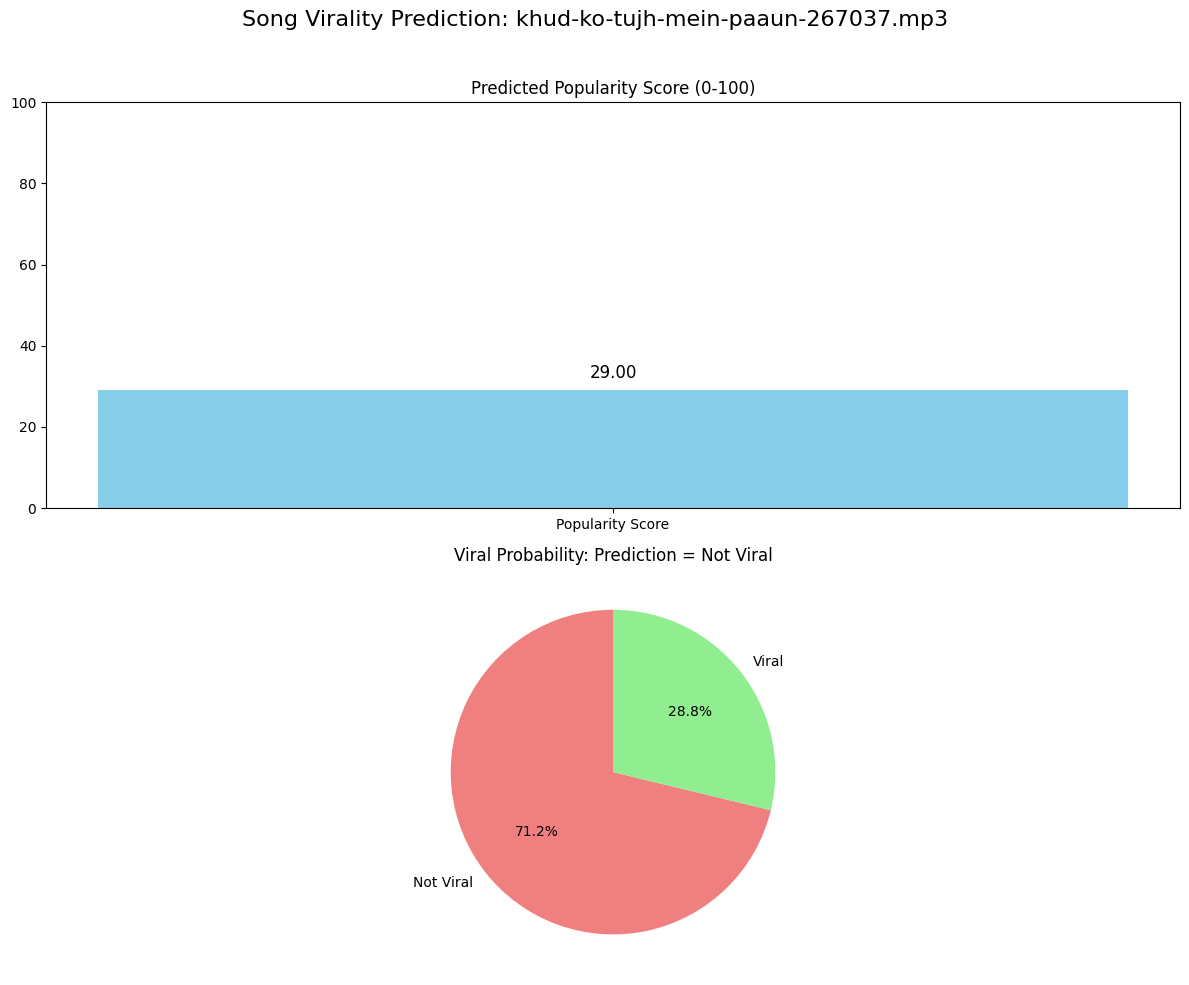


Prediction Summary for khud-ko-tujh-mein-paaun-267037.mp3:
Popularity Score: 29.00/100
Viral Probability: 28.77%
Prediction: Not Viral


In [5]:
# Test Case for Predicting Virality of Any Audio Song

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.feature
import warnings
warnings.filterwarnings('ignore')

def extract_features_from_audio(audio_file_path):
    """
    Extract Spotify-like audio features from an audio file using librosa.

    Parameters:
    audio_file_path (str): Path to the audio file

    Returns:
    dict: Dictionary containing the extracted features
    """
    print(f"Extracting features from {audio_file_path}...")

    # Load the audio file
    try:
        y, sr = librosa.load(audio_file_path, sr=22050)
    except Exception as e:
        print(f"Error loading audio file: {str(e)}")
        return None

    # Extract features that are similar to Spotify's audio features
    features = {}

    # Basic features
    features['duration_ms'] = len(y) / sr * 1000  # Duration in milliseconds

    # Rhythm features
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['energy'] = np.mean(spectral_centroids) / 100  # Normalized energy

    # Tonal features
    features['key'] = float(np.argmax(librosa.feature.chroma_cens(y=y, sr=sr).mean(axis=1)))

    # Zero crossing rate can relate to "acousticness"
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['acousticness'] = 1.0 - (np.mean(zcr) * 10)  # Inverse relationship
    features['acousticness'] = max(0.0, min(1.0, features['acousticness']))  # Ensure between 0 and 1

    # Danceability (approximation based on rhythm strength)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    features['danceability'] = min(1.0, np.mean(onset_env) / 10)  # Normalize

    # Loudness
    features['loudness'] = float(np.mean(librosa.feature.rms(y=y)[0]) * -20)  # Roughly convert to dB scale

    # Speechiness (based on MFCC variance)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features['speechiness'] = min(1.0, np.std(mfccs[0]) / 5)  # Higher variance might indicate speech

    # Instrumentalness (approximation)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['instrumentalness'] = min(1.0, np.mean(spectral_rolloff) / (sr/4))  # Higher rolloff might indicate instruments

    # Liveness (approximation based on dynamic range)
    features['liveness'] = min(1.0, np.std(librosa.feature.rms(y=y)[0]) * 10)  # Higher dynamic range might indicate live

    # Valence (emotional positiveness - approximation based on spectral characteristics)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features['valence'] = min(1.0, 0.5 + np.mean(spectral_contrast[1]) * 0.5)  # Normalize around 0.5

    # Mode (major or minor)
    features['mode'] = float(int(np.mean(librosa.feature.tonnetz(y=y, sr=sr)[0]) > 0))  # Simplified binary approximation

    # Time signature (approximation)
    features['time_signature'] = 4.0  # Default to 4/4 time

    # Add some default values for features that are harder to extract
    features['year'] = 2025.0  # Current year
    features['genre'] = 'unknown'  # Default genre

    print("Feature extraction complete.")

    return features

def predict_virality(audio_file_path, model_dir='.'):
    """
    Predict the virality of an audio file using the trained models.

    Parameters:
    audio_file_path (str): Path to the audio file
    model_dir (str): Directory containing the saved models

    Returns:
    dict: Prediction results
    """
    # Load the models
    try:
        reg_model = joblib.load(f'{model_dir}/popularity_regression_model.pkl')
        cls_model = joblib.load(f'{model_dir}/virality_classification_model.pkl')
        preprocessor = joblib.load(f'{model_dir}/feature_preprocessor.pkl')
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        print(f"Please ensure the models are available in {model_dir}")
        return None

    # Extract features from the audio file
    features = extract_features_from_audio(audio_file_path)
    if features is None:
        return None

    # Prepare the features for prediction
    song_features = pd.DataFrame([features])

    # Feature engineering - similar to what was used for training
    if 'energy' in song_features.columns and 'acousticness' in song_features.columns:
        song_features['energy_acousticness_ratio'] = song_features['energy'] / (song_features['acousticness'] + 0.01)

    if 'valence' in song_features.columns and 'energy' in song_features.columns:
        song_features['positivity'] = (song_features['valence'] + song_features['energy']) / 2

    if 'duration_ms' in song_features.columns:
        song_features['duration_min'] = song_features['duration_ms'] / 60000
        song_features.drop('duration_ms', axis=1, inplace=True)

    # Drop columns that might exist in the prediction data but not in the training data
    # This is a safety measure to ensure compatibility
    try:
        # Process the features using the preprocessor
        song_features_processed = preprocessor.transform(song_features)

        # Predict popularity score (regression)
        popularity_score = reg_model.predict(song_features_processed)[0]

        # Predict virality (classification)
        viral_prob = cls_model.predict_proba(song_features_processed)[0][1]
        is_viral = cls_model.predict(song_features_processed)[0]

        # Prepare the results
        results = {
            'popularity_score': popularity_score,
            'viral_probability': viral_prob,
            'is_viral': bool(is_viral)
        }

        return results
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

def visualize_prediction(results, audio_file_path):
    """
    Visualize the prediction results.

    Parameters:
    results (dict): Prediction results
    audio_file_path (str): Path to the audio file
    """
    if results is None:
        print("No results to visualize.")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'Song Virality Prediction: {audio_file_path.split("/")[-1]}', fontsize=16)

    # Popularity score visualization
    axes[0].bar(['Popularity Score'], [results['popularity_score']], color='skyblue')
    axes[0].set_title('Predicted Popularity Score (0-100)')
    axes[0].set_ylim([0, 100])
    axes[0].text(0, results['popularity_score'] + 2, f"{results['popularity_score']:.2f}",
                ha='center', va='bottom', fontsize=12)

    # Viral probability visualization
    colors = ['red', 'green']
    viral_status = 'Viral' if results['is_viral'] else 'Not Viral'
    viral_prob = results['viral_probability'] * 100
    non_viral_prob = (1 - results['viral_probability']) * 100

    axes[1].pie([non_viral_prob, viral_prob], labels=['Not Viral', 'Viral'],
               colors=['lightcoral', 'lightgreen'], autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Viral Probability: Prediction = {viral_status}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print a summary
    print(f"\nPrediction Summary for {audio_file_path.split('/')[-1]}:")
    print(f"Popularity Score: {results['popularity_score']:.2f}/100")
    print(f"Viral Probability: {results['viral_probability']:.2%}")
    print(f"Prediction: {'Viral' if results['is_viral'] else 'Not Viral'}")

# Example usage
def main():
    """
    Main function to test the virality prediction on a specific audio file.
    """
    # Replace with the path to your audio file
    audio_file_path = "/content/khud-ko-tujh-mein-paaun-267037.mp3"

    # Predict virality
    results = predict_virality(audio_file_path)

    # Visualize the prediction
    if results:
        visualize_prediction(results, audio_file_path)

if __name__ == "__main__":
    main()